In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import scipy
import time
import uuid

import matplotlib.pyplot as plt
import networkx as nx

from SPARQLWrapper import SPARQLWrapper, JSON, POST

from req_analysis import *

# Initialize connection to Neptune

In [3]:
%run 'req_analysis/libs/neptune-util.py'
%env NEPTUNE_CLUSTER_ENDPOINT=100.65.51.106
%env NEPTUNE_CLUSTER_PORT=8182
g = neptune.graphTraversal()

env: NEPTUNE_CLUSTER_ENDPOINT=100.65.51.106
env: NEPTUNE_CLUSTER_PORT=8182
gremlin: ws://100.65.51.106:8182/gremlin


# Evaluation

In [4]:
sparql = SPARQLWrapper("https://cae-mms-rdf-test-r5-2x.cluster-cw2hjngge6pe.us-gov-west-1.neptune.amazonaws.com:8182/sparql")

In [29]:
ref_targets = ReferenceTarget(sparql)
ref_targets.init_table()

== Status Code: 200 ==
1951 reference targets found.


In [30]:
ref_targets.table[0]

{'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_4663af6e-6265-438d-87b8-74e1550518bf__12328_01ea0ab4-0135-4d65-9f0c-895e6e3a696a',
 'name': 'Headquarters',
 'mms_id': '_4663af6e-6265-438d-87b8-74e1550518bf__12328_01ea0ab4-0135-4d65-9f0c-895e6e3a696a'}

In [6]:
req_evaluator = RequirementEvaluator(sparql)
req_evaluator.init_requirement_elements()

== Status Code: 200 ==
3061 requirements found.


In [ ]:
req_evaluator.evaluate_all_requirements(g, ref_targets, pprint=False)

1 / 1509 --- 0.2871859073638916 s
NO MATCH FOUND evaluation with req:  _1c8745d2-aa73-4371-b35a-bbb0e3124ce9__98_cd3fdddc-d986-4574-ab2b-9bc64eaaf3b6_asi-slot-_18_0_2_b4c02e1_1422576771659_877428_84042-slotvalue-0-literalstring
2 / 1509 --- 0.45852184295654297 s
NO MATCH FOUND evaluation with req:  _4663af6e-6265-438d-87b8-74e1550518bf__6762_4eeaf824-1f0a-4178-933d-8c01771b629d_asi-slot-_18_0_2_b4c02e1_1423073212164_663502_347367-slotvalue-0-literalstring
3 / 1509 --- 0.6321349143981934 s
NO MATCH FOUND evaluation with req:  _4663af6e-6265-438d-87b8-74e1550518bf__6572_1d3dd20d-9283-4015-b8c0-a3dee3fcfbe3_asi-slot-_18_0_2_b4c02e1_1422576771659_877428_84042-slotvalue-0-literalstring
4 / 1509 --- 1.320995807647705 s
NO MATCH FOUND evaluation with req:  _4663af6e-6265-438d-87b8-74e1550518bf__6762_4eeaf824-1f0a-4178-933d-8c01771b629d_asi-slot-_11_5EAPbeta_be00301_1147873226632_528960_2311-slotvalue-0-literalstring


/usr/local/anaconda3/envs/cref/lib/python3.7/site-packages/nltk/cluster/util.py:133: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (numpy.dot(u, v) / (sqrt(numpy.dot(u, u)) * sqrt(numpy.dot(v, v))))


5 / 1509 --- 1.8623926639556885 s
NO MATCH FOUND evaluation with req:  _4663af6e-6265-438d-87b8-74e1550518bf__6572_1d3dd20d-9283-4015-b8c0-a3dee3fcfbe3_asi-slot-_11_5EAPbeta_be00301_1147873226632_528960_2311-slotvalue-0-literalstring
6 / 1509 --- 2.0961458683013916 s
NO MATCH FOUND evaluation with req:  _8f7cabc1-8e5f-4014-8c9c-7ff7b8b98955__1371_1c1dbf6d-afd7-4903-b52a-f560db05995b_asi-slot-_18_0_2_b4c02e1_1422576771659_877428_84042-slotvalue-0-literalstring
7 / 1509 --- 2.2651917934417725 s
NO MATCH FOUND evaluation with req:  _4663af6e-6265-438d-87b8-74e1550518bf__6762_4eeaf824-1f0a-4178-933d-8c01771b629d_asi-slot-_18_0_2_b4c02e1_1422576771659_877428_84042-slotvalue-0-literalstring
8 / 1509 --- 2.9840128421783447 s
NO MATCH FOUND evaluation with req:  _18682_bd1fb593-def7-42f3-a50b-3b55236faee7_asi-slot-_11_5EAPbeta_be00301_1147873226632_528960_2311-slotvalue-0-literalstring
9 / 1509 --- 3.6805808544158936 s
NO MATCH FOUND evaluation with req:  _18682_bd1fb593-def7-42f3-a50b-3b55236

In [19]:
req_list = [
    '_831_331c90b6-9e17-4c46-8530-0fc345e0a22f_asi', 
    '_841_87af5944-6ea6-45b1-b787-f90cbfeec9b4_asi',
    '_1c8745d2-aa73-4371-b35a-bbb0e3124ce9__177_de0b38f1-5b92-496b-a528-89795aef8916_asi', 
    '_4663af6e-6265-438d-87b8-74e1550518bf__12410_7c88037b-e412-4c6f-a9c2-709bcbeb92ea_asi', 
]

gremlin: ws://100.65.51.106:8182/gremlin
Req ID:  https://opencae.jpl.nasa.gov/mms/rdf/element/_831_331c90b6-9e17-4c46-8530-0fc345e0a22f_asi 
Req text: <html><body>
<span xmlns="http://www.w3.org/1999/xhtml"><strong>[REQ-1-OAD-0185]</strong> The Observatory Safety system decomposition element is defined as follows:<br/>Associated WBS element(s): TMT.TEL.CONT.OSS<br/>The Observatory Safety System (OSS) contributes to the enforcement of safe conditions throughout the summit facility by continuously monitoring the state of connected equipment, systems and sensors and taking appropriate action as soon as an unsafe condition is detected. It is independent from and supplementary to any safety systems and functionality that is contained within individual subsystems. Based on one or more Programmable Logic Controllers (PLCs), it will interface with connected subsystems via a dedicated safety rated fieldbus based on EtherNet/IP; monitor interlock requests and possibly a defined subset of additi

b'[\n{\n    "type" : "UpdateEvent",\n    "totalElapsedMillis" : 0,\n    "elapsedMillis" : 0,\n    "connFlush" : 0,\n    "batchResolve" : 0,\n    "whereClause" : 0,\n    "deleteClause" : 0,\n    "insertClause" : 0\n},\n{\n    "type" : "Commit",\n    "totalElapsedMillis" : 8\n}\n]'

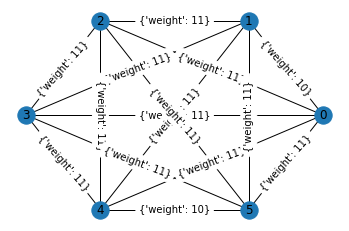

In [83]:
g = neptune.graphTraversal()

req_evaluation = req_evaluator.evaluate_req_by_id(g, 
                                 '_831_331c90b6-9e17-4c46-8530-0fc345e0a22f_asi', 
                                 ref_targets,
                                 pprint=True)
req_evaluation.insert_references()

Available methods for `req_evaluation` are:
- .get_matches()
- .get_allocations()
- .display_match_subgrap()

In [87]:
req_evaluation.init_cref_tags_text()

'<html><body>\n<span xmlns="http://www.w3.org/1999/xhtml"><strong>[REQ-1-OAD-0185]</strong> The Observatory Safety system decomposition element is defined as follows:<br/>Associated WBS element(s): TMT.TEL.CONT.OSS<br/>The Observatory Safety System (OSS) contributes to the enforcement of safe conditions throughout the summit facility by continuously monitoring the state of connected equipment, systems and sensors and taking appropriate action as soon as an unsafe condition is detected. It is independent from and supplementary to any safety systems and functionality that is contained within individual subsystems. Based on one or more Programmable Logic Controllers (PLCs), it will interface with connected subsystems via a dedicated safety rated fieldbus based on EtherNet/IP; monitor interlock requests and possibly a defined subset of additional signals from all connected subsystems; monitor the emergency stop switches located throughout the summit facility; manage safety interlock enforc

In [84]:
req_evaluation.get_matches()

{117: {'token': {'text': 'the Data Management System',
   'pos': 'PROPN',
   'token_id': 117,
   'whitespace': ' '},
  'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_16566_c270fe21-19e7-4d0d-aa3c-31b76ad6ca8b',
   'name': 'Data Management System',
   'mms_id': '_16566_c270fe21-19e7-4d0d-aa3c-31b76ad6ca8b'},
  'score': 0.0013642900507215298},
 124: {'token': {'text': 'Executive Software',
   'pos': 'PROPN',
   'token_id': 124,
   'whitespace': ' '},
  'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_17_0_2_3_41e01aa_1382542702961_630808_58999',
   'name': 'Executive Software',
   'mms_id': '_17_0_2_3_41e01aa_1382542702961_630808_58999'},
  'score': -0.0},
 141: {'token': {'text': 'network',
   'pos': 'PROPN',
   'token_id': 141,
   'whitespace': ' '},
  'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_6_876026b_1478280404909_609058_173008',
   'name': 'Network',
   'mms_id': '_18_0_6_876026b_1478280404909_609058

In [85]:
req_evaluation.get_allocations()

[{'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_16566_c270fe21-19e7-4d0d-aa3c-31b76ad6ca8b',
  'name': 'Data Management System',
  'mms_id': '_16566_c270fe21-19e7-4d0d-aa3c-31b76ad6ca8b'},
 {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_17_0_2_3_41e01aa_1382542702961_630808_58999',
  'name': 'Executive Software',
  'mms_id': '_17_0_2_3_41e01aa_1382542702961_630808_58999'},
 {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_6_876026b_1478280404909_609058_173008',
  'name': 'Network',
  'mms_id': '_18_0_6_876026b_1478280404909_609058_173008'},
 {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/MMS_1456189351681_ad25f82c-607f-4103-83b1-75f605015749',
  'name': 'Networking',
  'mms_id': 'MMS_1456189351681_ad25f82c-607f-4103-83b1-75f605015749'}]

In [20]:
req_evaluator.get_requirement_by_id('_831_331c90b6-9e17-4c46-8530-0fc345e0a22f_asi')

{'slot': {'type': 'uri',
  'value': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_831_331c90b6-9e17-4c46-8530-0fc345e0a22f_asi-slot-_11_5EAPbeta_be00301_1147873226632_528960_2311'},
 'instance': {'type': 'uri',
  'value': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_831_331c90b6-9e17-4c46-8530-0fc345e0a22f_asi'},
 'valueString': {'type': 'literal',
  'value': '<html><body>\n<span xmlns="http://www.w3.org/1999/xhtml"><strong>[REQ-1-OAD-0185]</strong> The Observatory Safety system decomposition element is defined as follows:<br/>Associated WBS element(s): TMT.TEL.CONT.OSS<br/>The Observatory Safety System (OSS) contributes to the enforcement of safe conditions throughout the summit facility by continuously monitoring the state of connected equipment, systems and sensors and taking appropriate action as soon as an unsafe condition is detected. It is independent from and supplementary to any safety systems and functionality that is contained within individual subsystems. Based on one or

# MISCELLANEOUS 

In [16]:
summit='_4663af6e-6265-438d-87b8-74e1550518bf__65_6314a138-53b9-42a5-b488-9c23967ed889'
enclosure='_18_0_6_f1d0357_1490143302007_461579_179266'
mirror='_18_5_2_e64033a_1509475358071_810923_58742'
aps_user='_17_0_2_3_41e01aa_1389730769202_855584_72742'
aps_mission='_17_0_2_3_41e01aa_1389728637481_651557_61606'
usr_part_aps_mission='_17_0_2_3_41e01aa_1389731842407_88153_73842'
value_aps_mission='_18_0_2_baa02e2_1421376436201_767368_80540'

In [17]:
from req_analysis.libs.neptune_wrapper import get_type_from_part_properties

In [18]:
g = neptune.graphTraversal()
g.V(aps_mission).toList()

gremlin: ws://100.65.51.106:8182/gremlin


[v[_17_0_2_3_41e01aa_1389728637481_651557_61606]]

In [ ]:
g = neptune.graphTraversal()
get_type_from_part_properties(g, aps_mission)